In [1]:
#plotter per unire più run e più posterior
#------------------Import--------------------------------
from scipy import interpolate
from scipy import integrate
import scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import numpy as np
#import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import os 
import statistics as stat
#folder='/home/rciancarella/DarkSirensStat/MyDSStat/results/'
folder='/home/raul/DarkSirensStat/MyDSStat/results/'
os.chdir(folder)

# DS Cat

In [2]:
runpath='Mega450-FullBig_00'#'Mega450-FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

In [11]:
#all_dls=np.loadtxt(runpath+'_DSs.txt', usecols=2)
os.chdir(datapath)
all_dls=np.loadtxt(runpath+'_DSs.txt', usecols=6)#if there is scattering
all_zs=np.loadtxt(runpath+'_DSs.txt', usecols=3)
dl_max=np.max(all_dls)
dl_min=np.min(all_dls)
dl_med=dl_min+(dl_max-dl_min)/2
idx_max=np.where(all_dls==dl_max)[0][0]
idx_min=np.where(all_dls==dl_min)[0][0]

ref_folder='/home/raul/DarkSirensStat/MyDSStat/'
cat_name='FullExplorer_big.txt'#FullExplorer_big.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
Uniform_Cat.columns=colnames
dlmaxcat=Uniform_Cat['Luminosity Distance'].max()


outsiders=np.where(all_dls>=dlmaxcat)[0]
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

idx_med=np.where(all_dls==find_nearest(all_dls, value=dl_med))[0][0]
print(outsiders)
print(idx_min,idx_max,idx_med)

[ 71  76 423]
233 423 220


In [12]:
print(dl_max,np.max(all_zs))
print(dl_min,np.min(all_zs))

21901.269016613085 2.198736956359116
474.7485464967944 0.093216075467836


# $\beta$-Plot

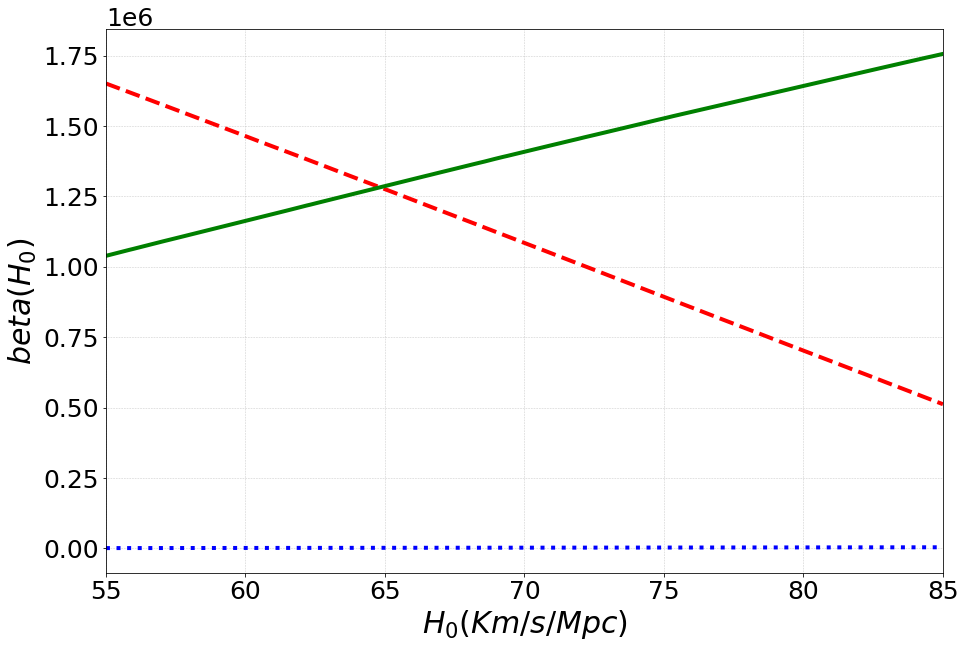

In [13]:
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
#betavol=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/volbeta/betatest_beta.txt')
betatest=np.loadtxt(runpath+'_beta.txt')

colors=pl.cm.turbo(np.linspace(0.1,0.99,len(betatest)))
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)

#for i in range(len(betatest)):
#    ax.plot(x,betatest[i],color=colors[i],linewidth=3,label='betatest'+str(i))

ax.plot(x,betatest[idx_max],label='betatest_dlmax',color='r',linewidth=4,linestyle='dashed')
ax.plot(x,betatest[idx_min],label='betatest_dlmin',color='b',linewidth=4,linestyle='dotted')
ax.plot(x,betatest[idx_med],label='betatest_dlmed',color='g',linewidth=4,linestyle='solid')
#ax.legend(fontsize=13, ncol=1)    

# Likelihood

In [14]:
likes=np.loadtxt(runpath +'_fullrun.txt')
NDS=np.shape(likes)[0]
#mybeta=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/MyBeta/MyBeta_beta.txt')

In [15]:
NDS=np.shape(likes)[0]
final_post_by_like=[]
for i in range(NDS):
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]
all_norm_post=[]
for i in range(NDS):
    post=likes[i]/betatest[i]
    post=post/np.trapz(post,x)
    all_norm_post.append(post)
#mytotpost=np.prod(all_norm_post)

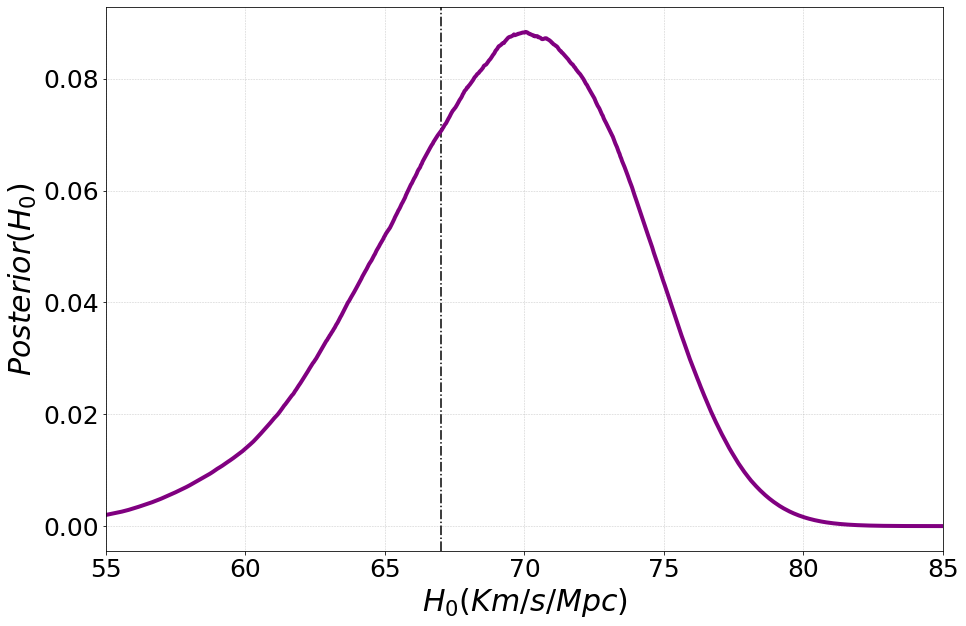

In [9]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
    #ax.plot(x,combined[i]/np.trapz(combined[i],x),label='Post',color=colors[i],linewidth=3,linestyle='solid')
#ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')
#ax.plot(x,combined[1]/np.trapz(combined[1],x),label='Post',color='purple',linewidth=4,linestyle='solid')
#aa=all_norm_post[1]*all_norm_post[0]
#ax.plot(x,aa/np.trapz(aa,x),label='Post',color='k',linewidth=4,linestyle='dotted')
#------------------------------Single posteriors--------------------------------------
#toplot=likes[idx_max]#/betatest[idx_max]
#ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='r',linewidth=4,linestyle='dashed')

#toplot=likes[idx_med]#/betatest[idx_med]
#ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='g',linewidth=4,linestyle='solid')

#toplot=likes[idx_min]#/betatest[idx_min]
#ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='b',linewidth=4,linestyle='dotted')
all_norm_post=[]
segment=[]
for i in range(201,230):
    post=likes[i]/betatest[i]
    post=post/np.trapz(post,x)
    all_norm_post.append(post) 
for i in range(len(all_norm_post)):
    #combined=combined+post[i]
    if i==0:
        segment.append(all_norm_post[i])
    else:
        num=np.float128(segment[i-1]*(all_norm_post[i]))
        segment.append(num)
ax.plot(x,segment[-1]/np.trapz(segment[-1],x),label='Post',color='purple',linewidth=4,linestyle='solid')

In [10]:
#per mega devi vedere tra 151 e 300 

# From Posterior

In [106]:
post=np.loadtxt(runpath+'_totpost.txt')

mean=62.71015638106364,std=4.702864179316968 std/mean=7.499366052828208%
mean=68.79256058720665,std=1.5860725090330474 std/mean=2.3055872546311487%


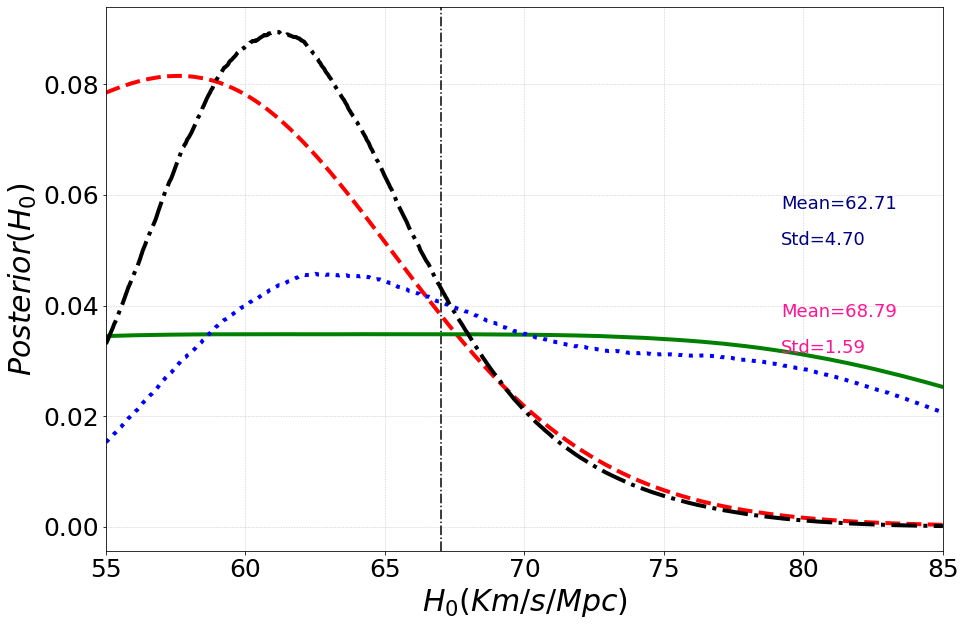

In [11]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

Mycol='navy'
Myshift='deeppink'
#ax.plot(x,post/np.trapz(post,x),label='Post',color=Mycol,linewidth=4,linestyle='solid')
#ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color=Myshift,linewidth=4,linestyle='solid')

toplot=likes[idx_max]/betatest[idx_max]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='r',linewidth=4,linestyle='dashed')
post_max=toplot
toplot=likes[idx_med]/betatest[idx_med]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='g',linewidth=4,linestyle='solid')
post_med=toplot
toplot=likes[idx_min]/betatest[idx_min]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='b',linewidth=4,linestyle='dotted')
post_min=toplot

test=post_min*post_med*post_max
ax.plot(x,test/np.trapz(test,x),label='Post',color='k',linewidth=4,linestyle='-.')

newdist=(test)/np.trapz(test,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

dist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c=Myshift)
plt.figtext(0.75,0.40,'Std={:0.2f}'.format(std),fontsize=18, c=Myshift)
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

os.chdir(datapath)
#plt.savefig('PlotTot.pdf', format="pdf", bbox_inches="tight")

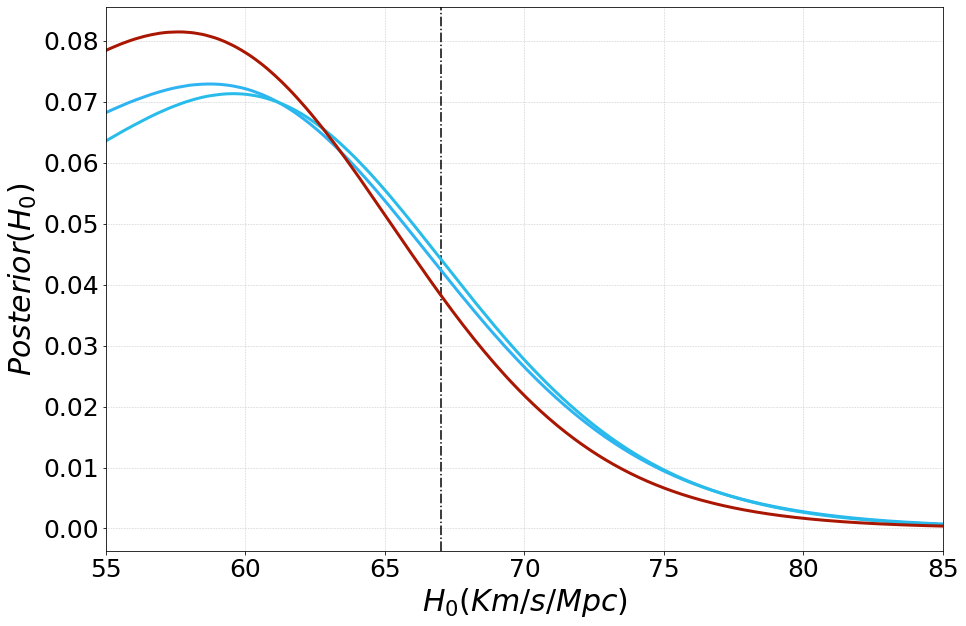

In [215]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
for i in outsiders:
    mypost=likes[i]/betatest[i]
    ax.plot(x,mypost/np.trapz(mypost,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))

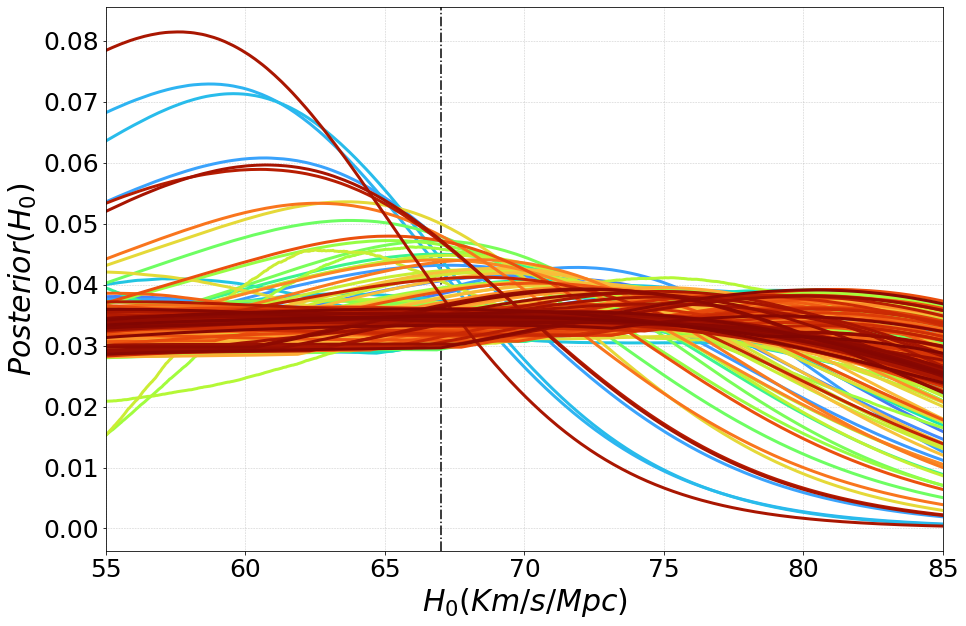

In [12]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

for i in range(len(betatest)):
    mypost=likes[i]/betatest[i]
    ax.plot(x,mypost/np.trapz(mypost,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))

[]
[172 173 174 175 176 177 178 179]


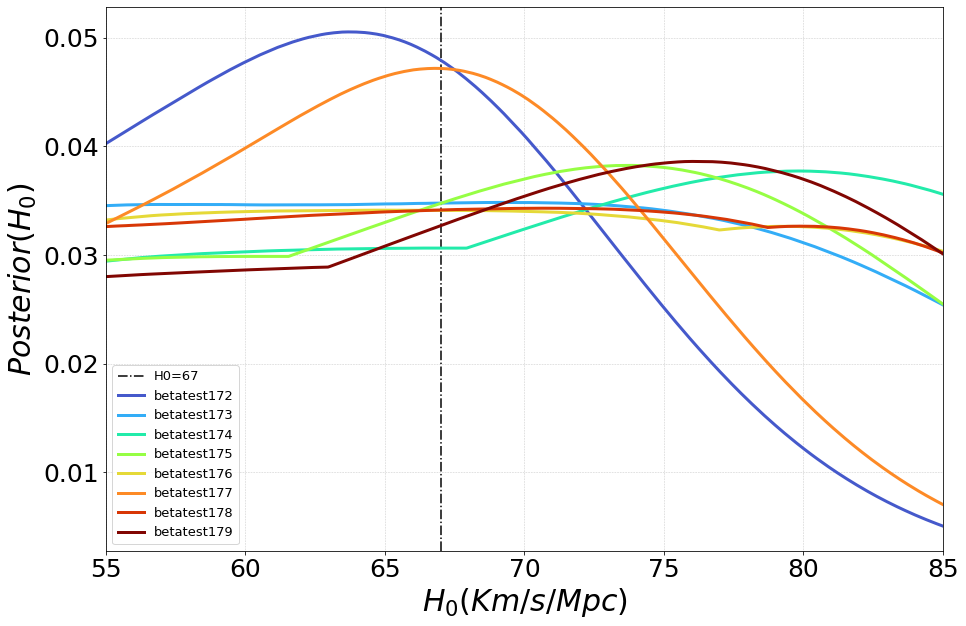

In [141]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
limit=len(betatest)
myselection=np.arange(172,180)
#print(myselection)
#print(myselection)
#togli 233
cutidx=np.where((myselection==233)|(myselection==169)|(myselection==171))[0]
print(cutidx)
myselection_new= np.delete(myselection,cutidx)
print(myselection_new)
selcol=pl.cm.turbo(np.linspace(0.1,0.99,len(myselection_new)))
for i in myselection_new:
    mypost=likes[i]/betatest[i]
    ax.plot(x,mypost/np.trapz(mypost,x),color=selcol[i-myselection_new[0]],linewidth=3,label=+str(i))
    #ax.plot(x,combined[maxrange]/np.trapz(combined[maxrange],x),color='k',linewidth=3)
    #ax.plot(x,betatest[i],color=selcol[i-myselection_new[0]],linewidth=3,label=str(i))
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)
ax.legend(fontsize=13, ncol=1)   

[]
[172 173 174 175 176 177 178 179]


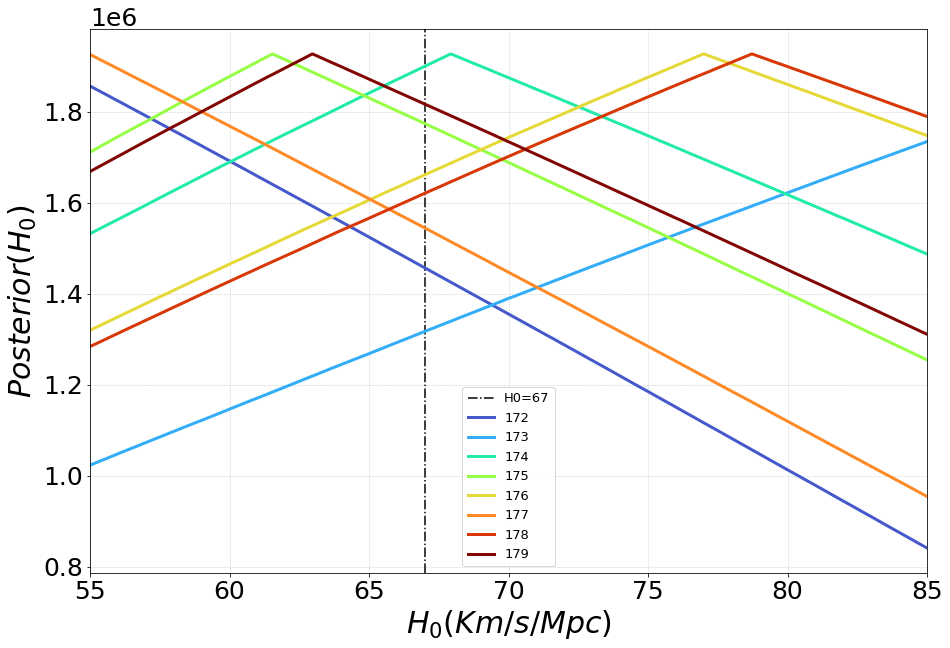

In [19]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
limit=len(betatest)
myselection=np.arange(172,180)
#print(myselection)
#print(myselection)
#togli 233
cutidx=np.where((myselection==233)|(myselection==169)|(myselection==171))[0]
print(cutidx)
myselection_new= np.delete(myselection,cutidx)
print(myselection_new)
selcol=pl.cm.turbo(np.linspace(0.1,0.99,len(myselection_new)))
for i in myselection_new:
    mypost=likes[i]/betatest[i]
    #ax.plot(x,mypost/np.trapz(mypost,x),color=selcol[i-myselection_new[0]],linewidth=3,label='betatest'+str(i))
    #ax.plot(x,combined[maxrange]/np.trapz(combined[maxrange],x),color='k',linewidth=3)
    ax.plot(x,betatest[i],color=selcol[i-myselection_new[0]],linewidth=3,label=str(i))
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)
ax.legend(fontsize=13, ncol=1)  

# Remove big Scattering

In [3]:
DS_Cat = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if DS_Cat.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if DS_Cat.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DS_Cat.columns=colnames
print(DS_Cat.shape[0])

450


In [16]:
np.mean(DS_Cat['scattered DL'])

10635.688154365112

In [17]:
np.mean(DS_Cat['Luminosity Distance'])

10630.908602282214

In [7]:
sigma=DS_Cat['Luminosity Distance']*0.1
sigmadist=(DS_Cat['Luminosity Distance']-DS_Cat['scattered DL'])/sigma
sigmadist_abs=np.absolute(sigmadist)
towork=DS_Cat
towork['sigma_dist']=sigmadist
towork=towork[towork['sigma_dist']<=1]
towork=towork[towork['sigma_dist']>=-1]
print(towork.shape[0],DS_Cat.shape[0],towork.shape[0]/DS_Cat.shape[0])
temp=np.where(sigmadist_abs<1)[0]

319 450 0.7088888888888889


In [16]:
beta_filtered=betatest[temp]
like_filtered=likes[temp]

In [17]:
NDS=np.shape(like_filtered)[0]
final_post_filtered=[]
for i in range(NDS):
    final_post_filtered.append(like_filtered[i]/beta_filtered[i])
combined_filtered=[]
for i in range(len(final_post_filtered)):
    #combined=combined+post[i]
    if i==0:
        combined_filtered.append(final_post_filtered[i])
    else:
        num=np.float128(combined_filtered[i-1]*(final_post_filtered[i]))
        combined_filtered.append(num)
totpost_filtered=combined_filtered[-1]
all_norm_filtered=[]
for i in range(NDS):
    post_filtered=like_filtered[i]/beta_filtered[i]
    post_filtered=post_filtered/np.trapz(post_filtered,x)
    all_norm_filtered.append(post)

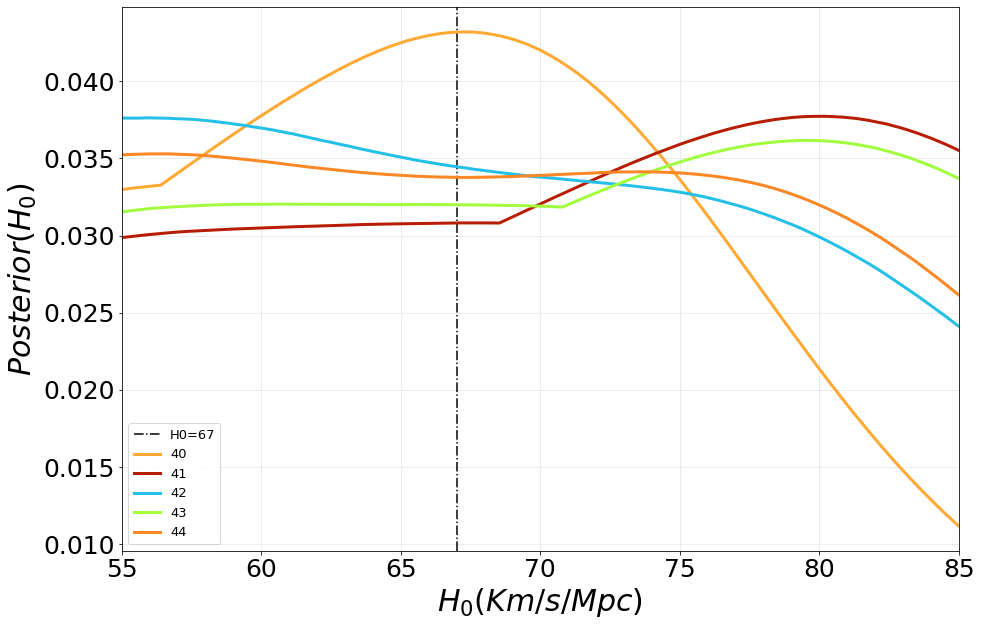

In [62]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
selcol=pl.cm.turbo(np.linspace(0.1,0.99,len(like_filtered)))
for i in range(40,45):
    mypost=like_filtered[i]/beta_filtered[i]
    ax.plot(x,mypost/np.trapz(mypost,x),color=selcol[i**2-1707],linewidth=3,label=str(i))
    #ax.plot(x,combined_filtered[i]/np.trapz(combined_filtered[i],x),color=selcol[i],linewidth=3)
    #ax.plot(x,beta_filtered[i],color=selcol[i*5+20],linewidth=3,label=str(i))
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=selcol[i**2-1707],linewidth=3,label=str(i))
#ax.plot(x,totpost_filtered/np.trapz(totpost_filtered,x),color='teal',linewidth=3)
ax.legend(fontsize=13, ncol=1)   

In [38]:
towork[40:45]

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta,scattered DL,sigma_dist
52,2867885,5461.778870,16900.907208,2.094396,1.353392,0.647485,18431.060163,-0.905367
54,2869113,5345.112983,16104.444194,2.012929,0.748095,1.414410,15167.315036,0.581907
56,2104119,2901.133127,5238.788336,0.805773,0.609611,0.826659,4970.808174,0.511531
59,2935263,5295.269491,15774.781178,1.979033,1.400161,1.170993,14684.139110,0.691383
60,1911366,3767.491029,8094.267291,1.148450,0.551098,0.597918,8378.259153,-0.350856


# Close Study 

In [60]:
import pandas as pd

In [61]:
DS_Cat = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if DS_Cat.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if DS_Cat.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DS_Cat.columns=colnames
print(DS_Cat.shape[0])

150


In [62]:
DS_Cat.head(3)

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta
0,2689474,1618.082317,2267.900333,0.401598,0.475918,1.312600
1,151787,5099.303149,14536.916290,1.850765,1.049170,1.106915
2,1287984,4391.731895,10739.766275,1.445451,1.322997,1.332440


In [63]:
selected=DS_Cat[DS_Cat['z']>=2]
print(selected.shape[0])
selected.head()

25


,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta
4,211928,5481.633685,17040.021608,2.108566,0.611414,0.678642
6,532400,5567.078374,17650.961019,2.170597,0.424429,0.649934
18,113897,5579.049370,17738.174406,2.179426,0.233124,1.118801
25,895421,5416.916696,16590.441474,2.062709,1.395937,0.497837
27,2116205,5428.128614,16667.534804,2.070586,0.712665,0.470687


In [64]:
myselection=np.asarray(selected.index.values)

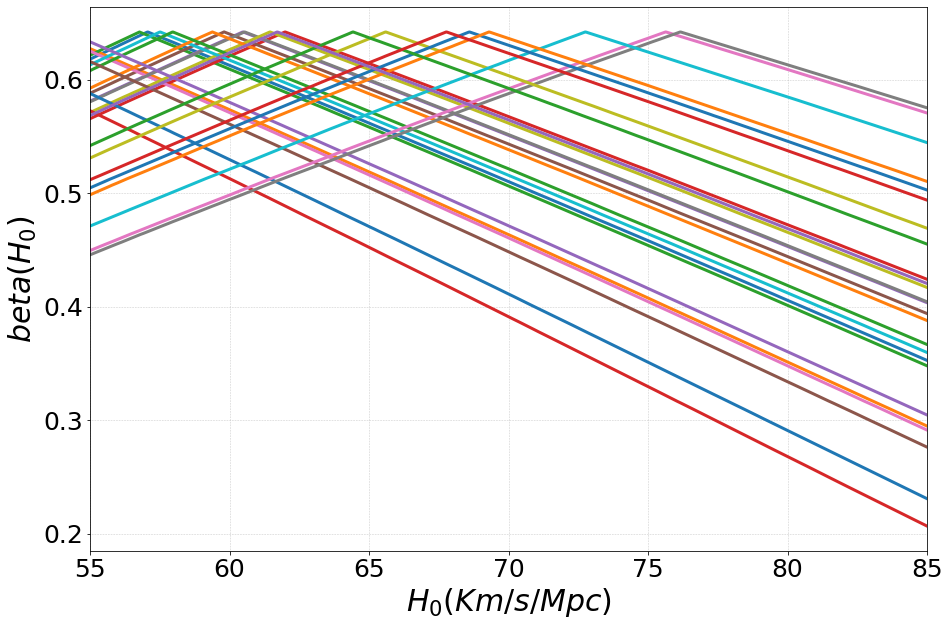

In [65]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)
for i in myselection:
    ax.plot(x,betatest[i],linewidth=3,label='betatest'+str(i))
#ax.plot(x,betatest[idx_max],label='betatest_dlmax',color='r',linewidth=4,linestyle='dashed')

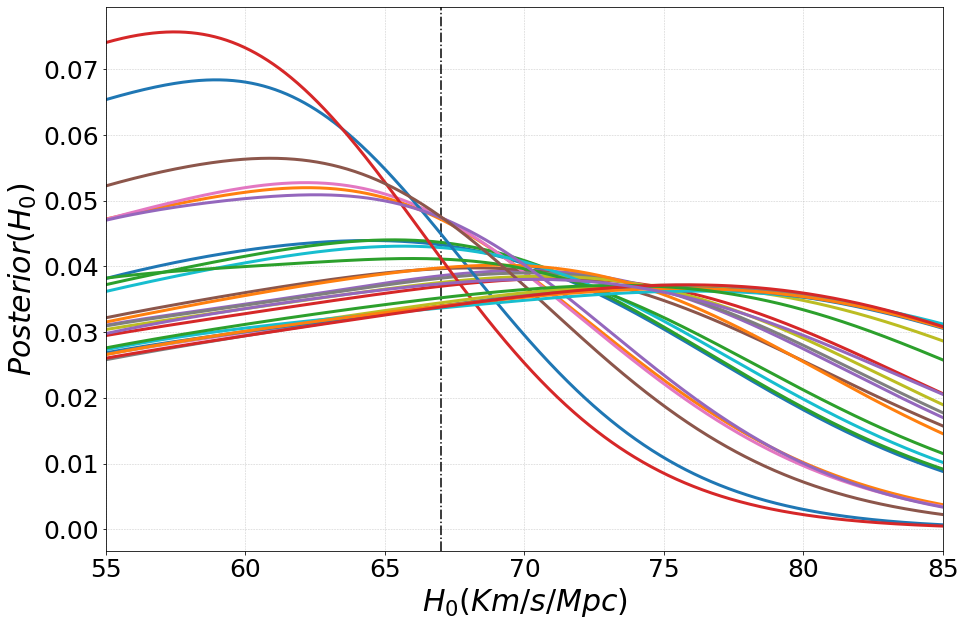

In [66]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
for i in myselection:
    toplot=likes[i]
    ax.plot(x,toplot/np.trapz(toplot,x),linewidth=3)
    

In [67]:
for i in myselection:
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]

Text(0.75, 0.55, 'Std=2.34')

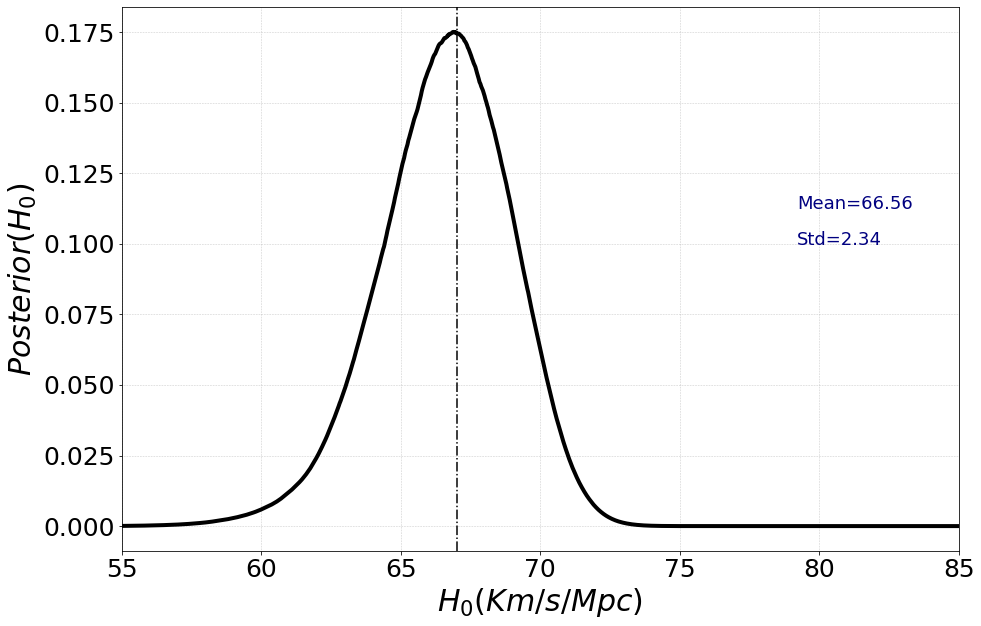

In [68]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)

In [72]:
selected=DS_Cat[DS_Cat['z']<=1]
print(selected.shape[0])
selected.head()

34


,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta
0,2689474,1618.082317,2267.900333,0.401598,0.475918,1.312600
3,2206625,3371.199598,6685.125137,0.983011,0.526214,1.210379
11,2543150,476.178864,528.239440,0.109330,0.809362,0.986415
14,226257,2692.754335,4666.318608,0.732917,0.557128,1.016229
15,355149,2986.465124,5484.850510,0.836569,0.258886,0.553958


In [73]:
myselection=np.asarray(selected.index.values)

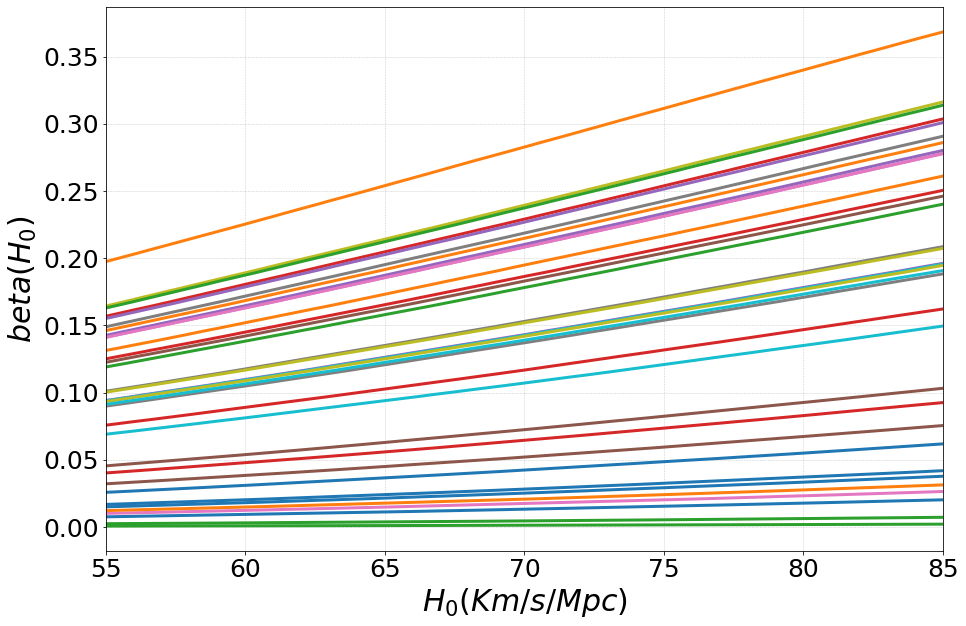

In [74]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)
for i in myselection:
    ax.plot(x,betatest[i],linewidth=3,label='betatest'+str(i))
#ax.plot(x,betatest[idx_min],label='betatest_dlmin',color='b',linewidth=4,linestyle='dotted')

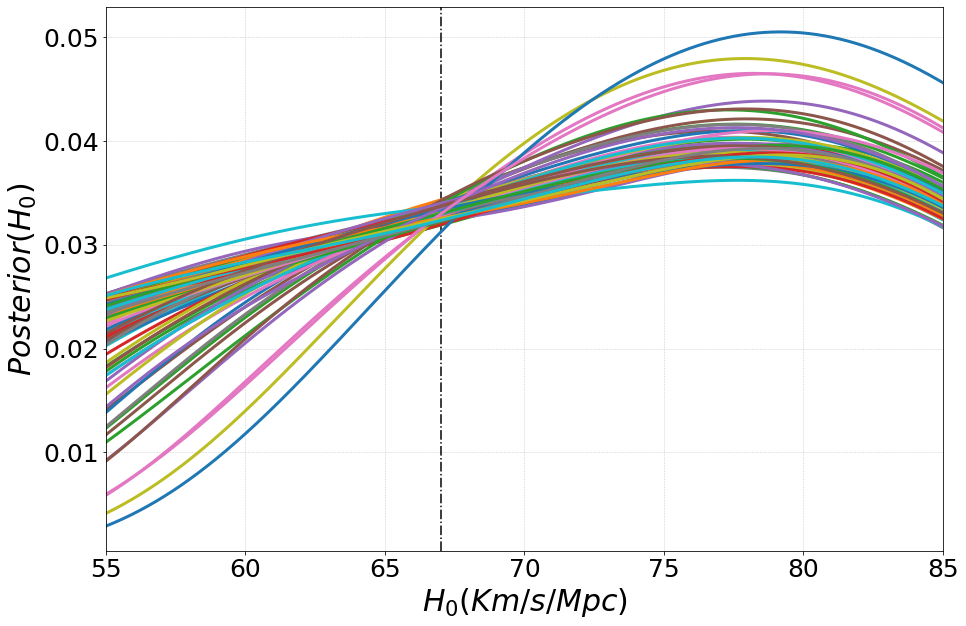

In [45]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
myselection_new= np.delete(myselection,[22])
for i in myselection:
    toplot=likes[i]
    ax.plot(x,toplot/np.trapz(toplot,x),linewidth=3)

In [46]:
for i in myselection:
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]

Text(0.75, 0.55, 'Std=1.08')

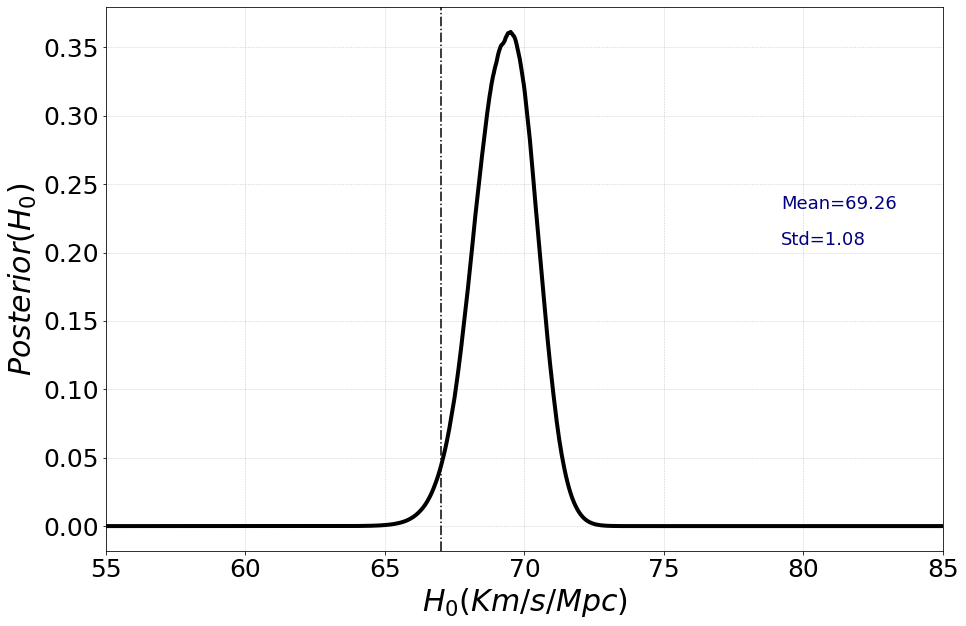

In [47]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)

# Scatter

In [3]:
import pandas as pd

In [111]:
scatter_runpath='Mega450-FullBig_00'#'P0_postback-scatter'#runpath
scatter_datapath=os.path.join(folder,scatter_runpath)
os.chdir(scatter_datapath)
print(scatter_datapath)

/home/raul/DarkSirensStat/MyDSStat/results/BorderCheck_FullBig_01


In [112]:
DS_Cat = pd.read_csv(scatter_runpath+'_DSs.txt', sep=" ", header=None)
if DS_Cat.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
    print('Dataframe has no Scatter')
if DS_Cat.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DS_Cat.columns=colnames
print(DS_Cat.shape[0])

150


In [113]:
truedl=DS_Cat['Luminosity Distance']
scattereddl=DS_Cat['scattered DL']
diff=truedl-scattereddl
allsigma=0.1*truedl

Text(0, 0.5, '$N$')

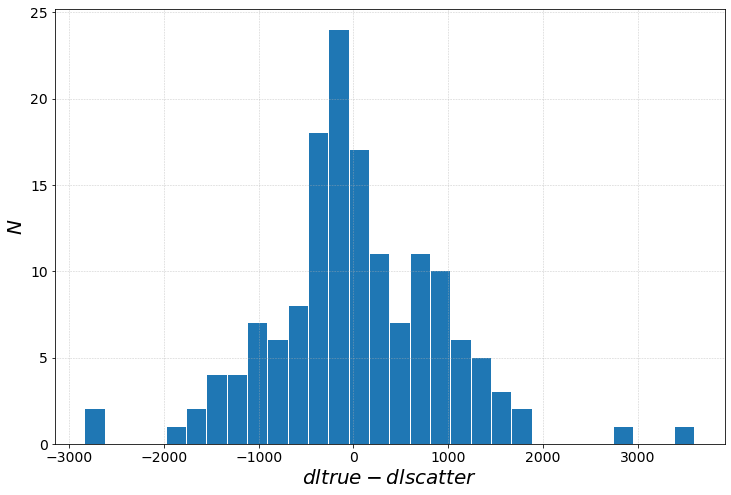

In [114]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(diff,bins=nbins,range=(np.min(diff),np.max(diff)),rwidth=0.95)

ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [115]:
mean=np.mean(diff)
std=np.std(diff)
print(mean,std)

26.120478580942216 904.2384204139278


In [116]:
norm_diff=diff/allsigma
print(np.mean(norm_diff))
test=norm_diff[norm_diff>=-1]
test=test[test<=1]
print(len(test)/len(norm_diff))

0.017970901100447714
0.7066666666666667


In [117]:
print(allsigma[0],diff[0],truedl[0])

1122.4442576113122 534.4524349155872 11224.442576113122


2.0724163126336256e-17


Text(0, 0.5, '$N$')

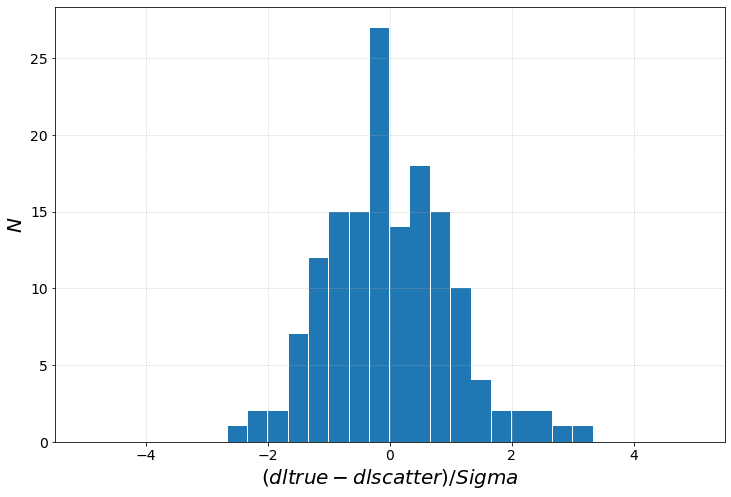

In [118]:
norm_diff=norm_diff-np.mean(norm_diff)
print(np.mean(norm_diff))
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n_norm, bins_norm, patches)=ax.hist(norm_diff,bins=nbins,
                                     range=(-5,5),rwidth=0.96)

ax.set_xlabel(r'$(dl true-dl scatter) / Sigma$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [119]:
mean=np.mean(norm_diff)
std=np.std(norm_diff)
median=np.median(norm_diff)
print(mean,std,median)
skw=3*(mean-median)/std
print(skw)

2.0724163126336256e-17 1.0097155490827603 -0.07089443892677516
0.2106368639895959


In [82]:
dl=np.linspace(1000,30000,60000)
scat=np.zeros(len(dl))
mysigma=dl*0.1
for i in range(len(dl)):
    scat[i]=np.random.normal(loc=dl[i], scale=mysigma[i], size=None)

In [83]:
mydiff=dl-scat
mynormdiff=mydiff/mysigma

Text(0, 0.5, '$N$')

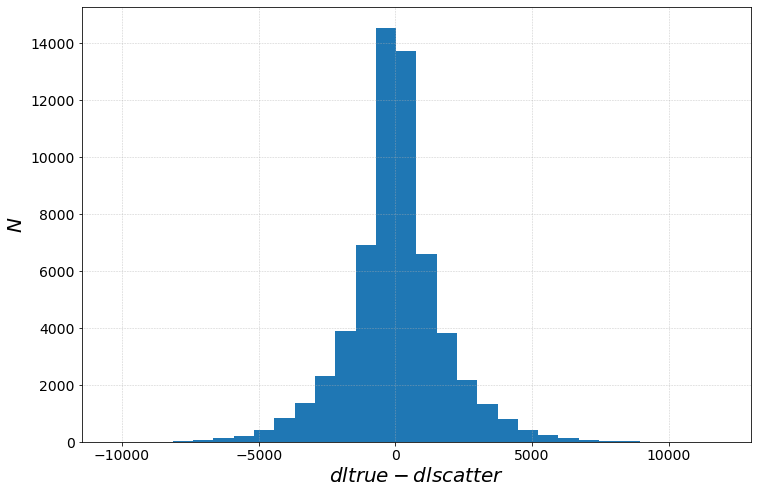

In [84]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(mydiff,bins=nbins,range=(np.min(mydiff),np.max(mydiff)))

ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

9449.556850633735


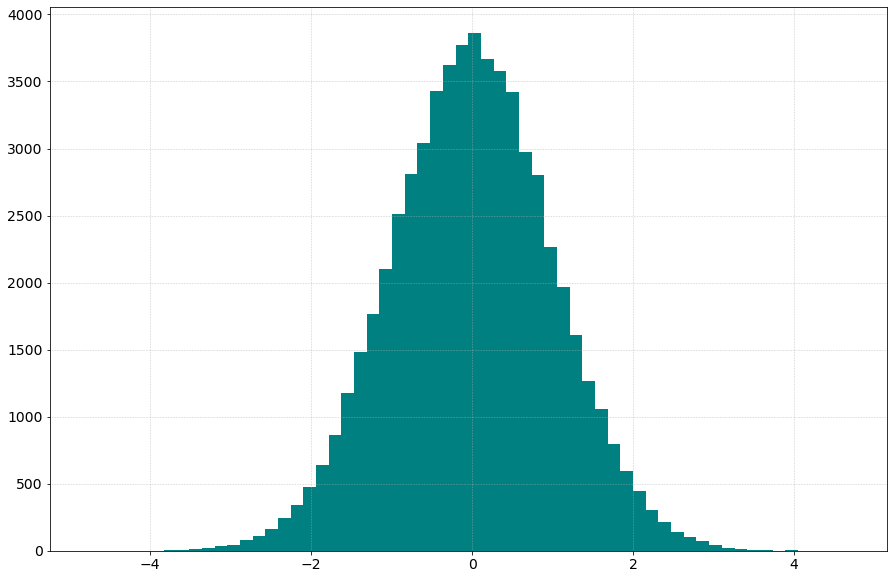

In [85]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=60
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)),
                                     density=False,color='teal')
rectangle=[]
for i in range(len(bins_norm)-1):
    base=bins_norm[i+1]-bins_norm[i]
    tmp=base*n_norm[i]
    rectangle.append(tmp)
nn=np.sum(rectangle)
print(nn)
dens=np.sum(n_norm)*np.diff(bins_norm)

#mymax=np.max(n_norm)
#mynorm=mymax_nonorm/mymax



Text(0, 0.5, '$N$')

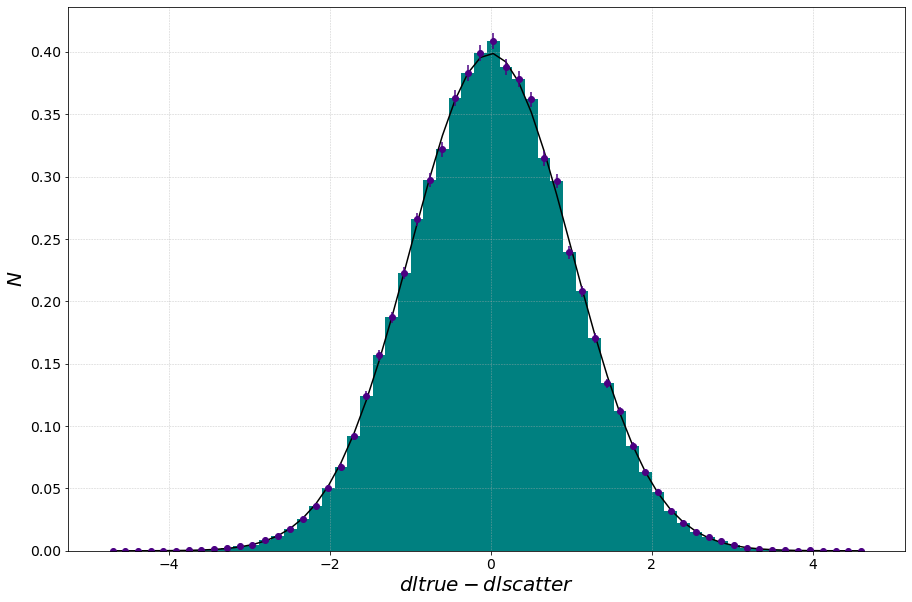

In [86]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
nbins=60
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)),
                                     density=True,color='teal')

gg=lambda x: np.exp(-(x**2)/2)*(1/np.sqrt(2*np.pi))
xsigma_min=np.min(bins_norm)
xsigma_max=np.max(bins_norm)
halfstep=(bins_norm[1]-bins_norm[0])/2
mypoints=bins_norm[0:-1]+halfstep
ax.plot(mypoints,gg(mypoints),color='k')

ax.errorbar(mypoints,n_norm,yerr=np.sqrt(n_norm/nn),fmt='o',color='indigo')
ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [90]:
mean=np.mean(mydiff)
std=np.std(mydiff)
print(mean,std)
print('Prop. of normed hist\n Mean\t std\t Median')
mean=np.mean(mynormdiff)
std=np.std(mynormdiff)
median=np.median(mynormdiff)
print(mean,std,median)
skw=3*(mean-median)/std
print(skw)

2.403519681257457 1764.1432414444841
Prop. of normed hist
 Mean	 std	 Median
-0.000396852487817563 0.9986301440541352 -0.0012364524961957827
0.002522255151350725


In [88]:
test=mynormdiff[mynormdiff>=-1]
test=test[test<=1]
print(len(test)/len(mynormdiff))
test=mynormdiff[mynormdiff>=-2]
test=test[test<=2]
print(len(test)/len(mynormdiff))
test=mynormdiff[mynormdiff>=-3]
test=test[test<=3]
print(len(test)/len(mynormdiff))


0.6854166666666667
0.9545333333333333
0.9971833333333333
0.002522255151350725


9006.948329829249


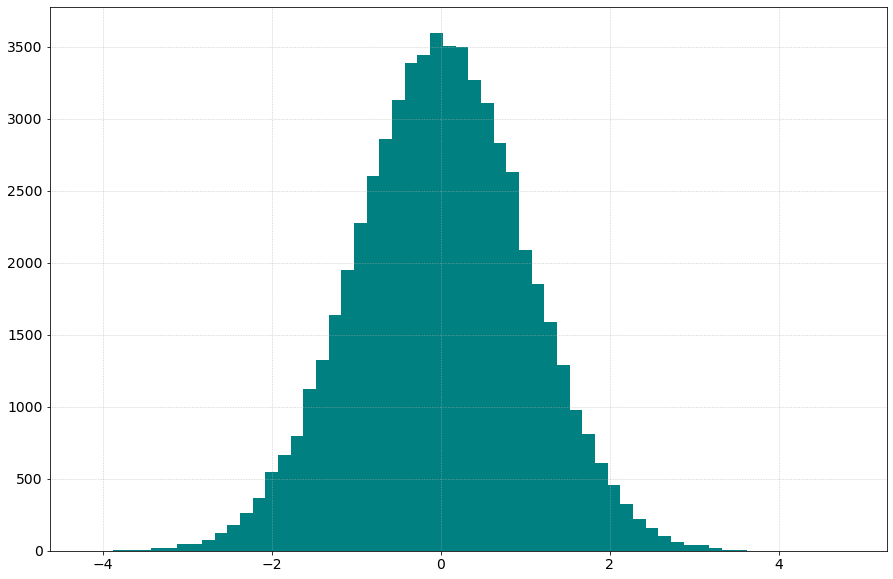

In [67]:
mynormdiff=mynormdiff-mean

fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=60
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)),
                                     density=False,color='teal')
rectangle=[]
for i in range(len(bins_norm)-1):
    base=bins_norm[i+1]-bins_norm[i]
    tmp=base*n_norm[i]
    rectangle.append(tmp)
nn=np.sum(rectangle)
print(nn)
dens=np.sum(n_norm)*np.diff(bins_norm)

Text(0, 0.5, '$N$')

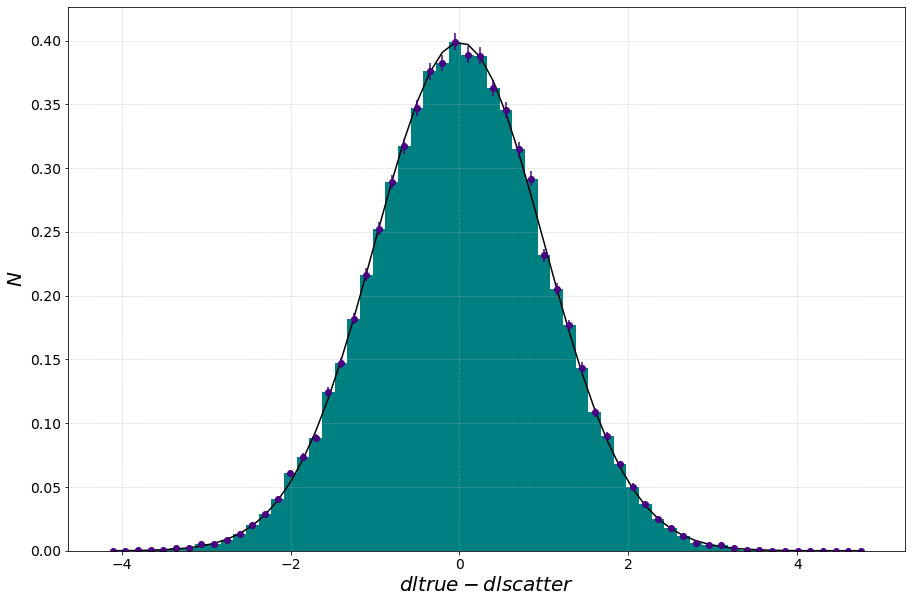

In [68]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
nbins=60
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)),
                                     density=True,color='teal')

gg=lambda x: np.exp(-(x**2)/2)*(1/np.sqrt(2*np.pi))
xsigma_min=np.min(bins_norm)
xsigma_max=np.max(bins_norm)
halfstep=(bins_norm[1]-bins_norm[0])/2
mypoints=bins_norm[0:-1]+halfstep
ax.plot(mypoints,gg(mypoints),color='k')

ax.errorbar(mypoints,n_norm,yerr=np.sqrt(n_norm/nn),fmt='o',color='indigo')
ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [125]:
mean=np.mean(mynormdiff)
std=np.std(mynormdiff)
median=np.median(mynormdiff)
print(mean,std,median)

test=mynormdiff[mynormdiff>=-1]
test=test[test<=1]
print(len(test)/len(mynormdiff))
test=mynormdiff[mynormdiff>=-2]
test=test[test<=2]
print(len(test)/len(mynormdiff))
test=mynormdiff[mynormdiff>=-3]
test=test[test<=3]
print(len(test)/len(mynormdiff))
skw=3*(mean-median)/std
print(skw)
print(scipy.stats.kurtosis(mynormdiff))


7.697546304067752e-18 1.0045263048387012 0.003410775452147629
0.6801833333333334
0.9538166666666666
0.9969
-0.010186220417678249
-0.02119053766646184
-0.00339540680589275


# Confronto Cataloghi DS

In [101]:
#----------Run singola 450--------------------------------
import pandas as pd
runpath='BorderCheck_FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

Mega = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if Mega.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if Mega.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
Mega.columns=colnames
#---------------prima run omogenea sottostima
runpath='EnzoTest_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sotto_00 = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if sotto_00.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sotto_00.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sotto_00.columns=colnames

runpath='EnzoTest_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sotto_01 = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if sotto_01.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sotto_01.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sotto_01.columns=colnames

runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sotto_02 = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if sotto_02.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sotto_02.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sotto_02.columns=colnames

sotto_tot=pd.DataFrame(columns=colnames)
sotto_tot = pd.concat([sotto_00, sotto_01,sotto_02], ignore_index=True)

#Mega.head()
#sotto_tot.head()

print(Mega.shape,sotto_tot.shape)

(150, 7) (450, 7)


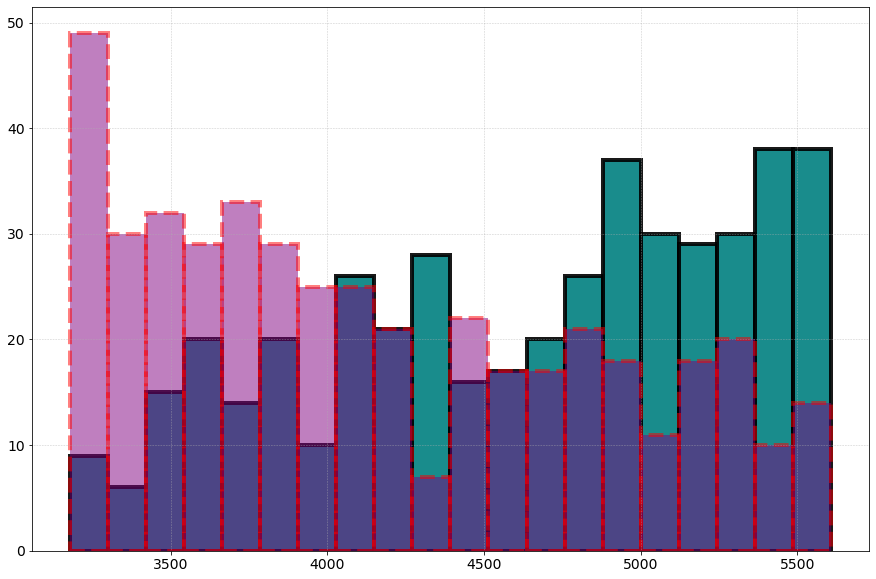

In [117]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_mega, bins_mega, patches)=ax.hist(Mega['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=False,color='teal',linestyle='solid',lw=4,alpha=0.9, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=False,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

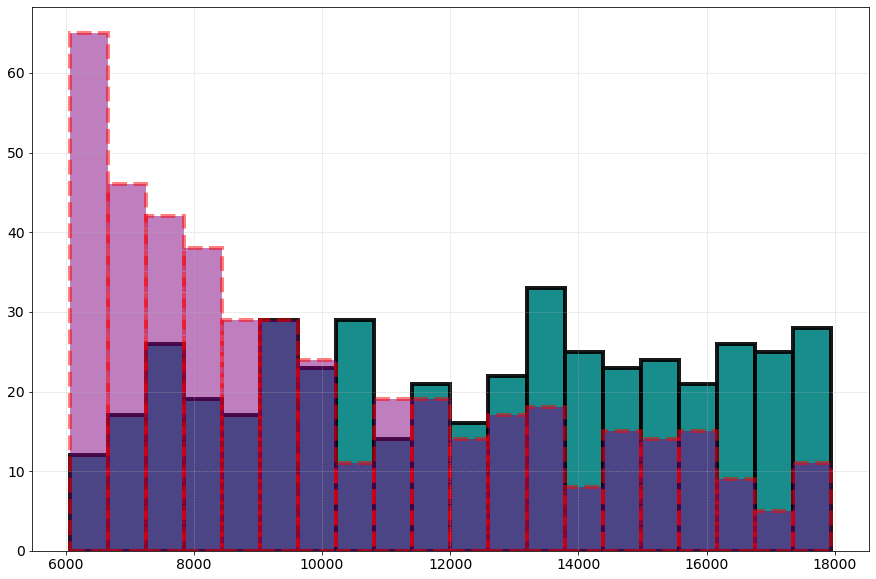

In [118]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_mega, bins_mega, patches)=ax.hist(Mega['Luminosity Distance'],bins=nbins,range=(np.min(Mega['Luminosity Distance']),np.max(Mega['Luminosity Distance'])),
                                     density=False,color='teal',linestyle='solid',lw=4,alpha=0.9, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['Luminosity Distance'],bins=nbins,range=(np.min(Mega['Luminosity Distance']),np.max(Mega['Luminosity Distance'])),
                                     density=False,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

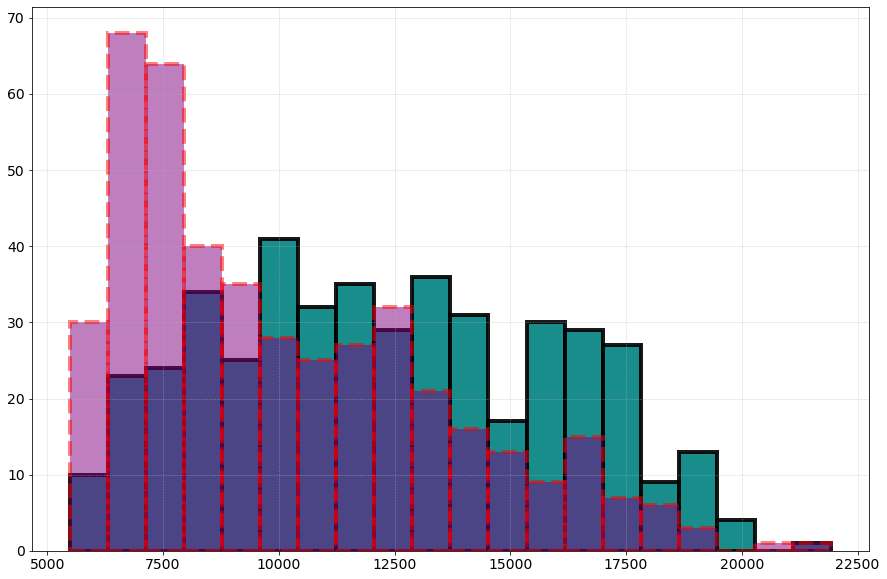

In [115]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_mega, bins_mega, patches)=ax.hist(Mega['scattered DL'],bins=nbins,range=(np.min(Mega['scattered DL']),np.max(Mega['scattered DL'])),
                                     density=False,color='teal',linestyle='solid',lw=4,alpha=0.9, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['scattered DL'],bins=nbins,range=(np.min(Mega['scattered DL']),np.max(Mega['scattered DL'])),
                                     density=False,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

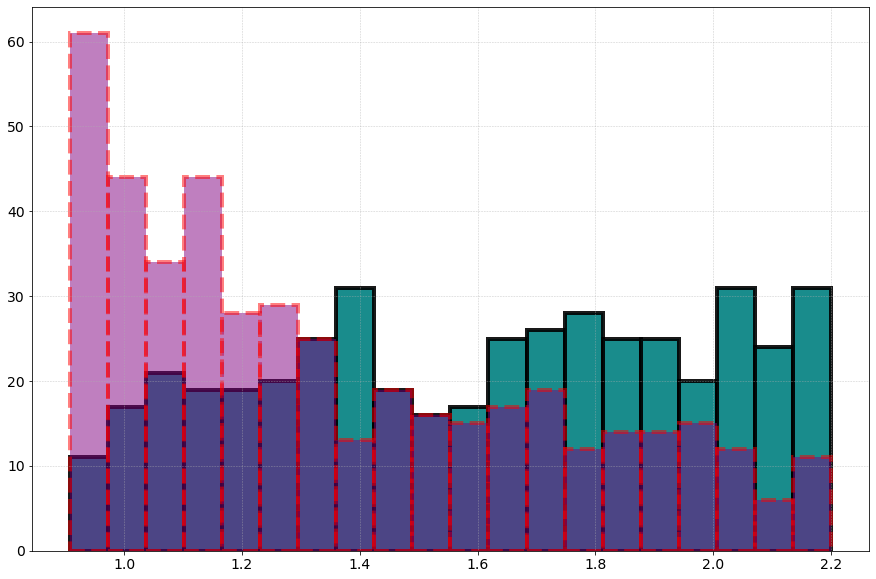

In [116]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_mega, bins_mega, patches)=ax.hist(Mega['z'],bins=nbins,range=(np.min(Mega['z']),np.max(Mega['z'])),
                                     density=False,color='teal',linestyle='solid',lw=4,alpha=0.9, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['z'],bins=nbins,range=(np.min(Mega['z']),np.max(Mega['z'])),
                                     density=False,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

In [120]:
#----------Run singola 450--------------------------------
import pandas as pd
runpath='P0_postback'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

ref = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if ref.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if ref.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
ref.columns=colnames

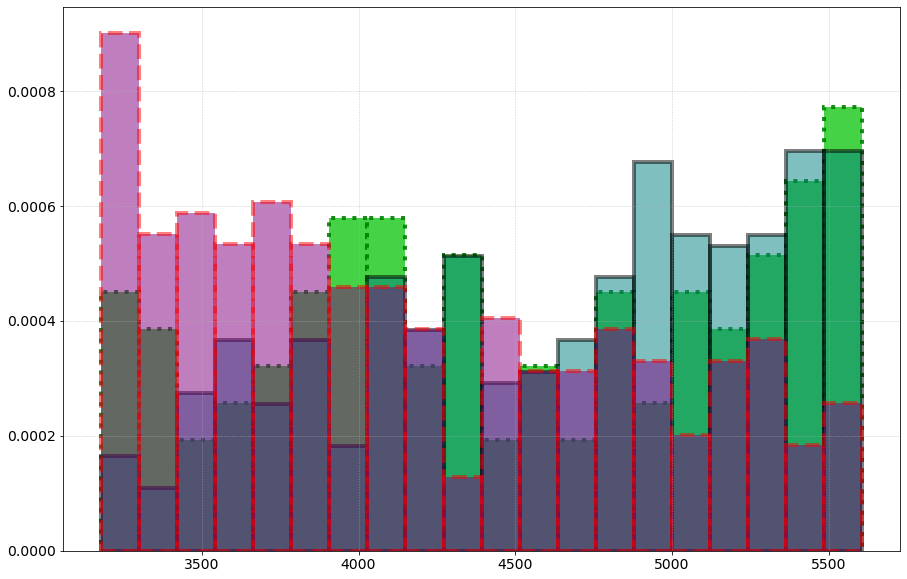

In [122]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

nbins=20
(n_ref, bins_ref, patches)=ax.hist(ref['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=True,color='limegreen',linestyle='dotted',lw=4,alpha=0.9, edgecolor = 'green')

(n_mega, bins_mega, patches)=ax.hist(Mega['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=True,color='teal',linestyle='solid',lw=4,alpha=0.5, edgecolor = 'k')

(n_sotto, bins_sotto, patches)=ax.hist(sotto_tot['Comoving Distance'],bins=nbins,range=(np.min(Mega['Comoving Distance']),np.max(Mega['Comoving Distance'])),
                                     density=True,color='purple',linestyle='--',lw=4,alpha=0.5, edgecolor = 'r')

# Merge More Runs

In [108]:
runpath='EnzoTest_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
beta_merge=np.loadtxt(runpath+'_beta.txt')
likelihood_merge=np.loadtxt(runpath +'_fullrun.txt')

In [109]:
runpath='EnzoTest_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

tmp=np.loadtxt(runpath+'_beta.txt')
beta_merge=np.append(beta_merge,tmp,axis=0)
tmp=np.loadtxt(runpath +'_fullrun.txt')
likelihood_merge=np.append(likelihood_merge,tmp,axis=0)

In [110]:
#runpath='Pesi-extracted-nodenom-02'
runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

tmp=np.loadtxt(runpath+'_beta.txt')
beta_merge=np.append(beta_merge,tmp,axis=0)
tmp=np.loadtxt(runpath +'_fullrun.txt')
likelihood_merge=np.append(likelihood_merge,tmp,axis=0)

In [112]:
NDS_merge=len(beta_merge)

In [113]:
runpath='Mega450-Cutted_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

beta_mega=np.loadtxt(runpath+'_beta.txt')
likelihood_mega=np.loadtxt(runpath +'_fullrun.txt')


nMega=len(beta_mega)
post_mega=[]
for i in range(NDS_merge):
    post_mega.append(likelihood_mega[i]/beta_mega[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(post_mega[i]*1)
    else:
        num=np.float128(combined[i-1]*(post_mega[i]*1))
        combined.append(num)
totpost_mega=combined[-1]

NameError: name 'final_post_merge' is not defined

In [114]:
final_post_merge=[]
for i in range(NDS_merge):
    final_post_merge.append(likelihood_merge[i]/beta_merge[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_merge[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_merge[i]*1))
        combined.append(num)
totpost_like=combined[-1]

Text(0.75, 0.55, 'Std=1.75')

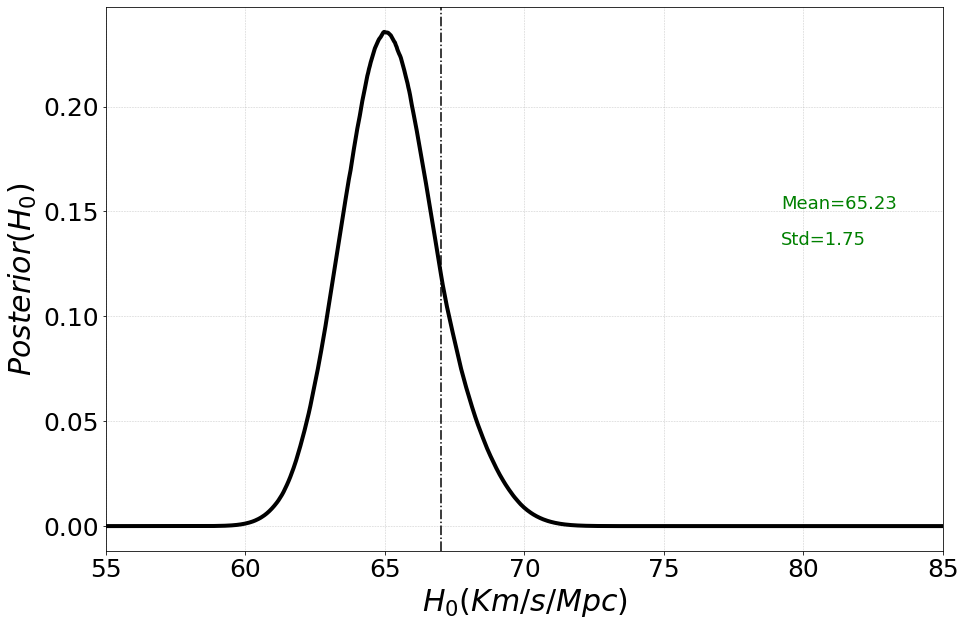

In [115]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')
#ax.plot(x,totpost_mega/np.trapz(totpost_mega,x),label='Post',color='r',linewidth=4,linestyle='solid')
#new_900=np.float128(totpost_mega/np.trapz(totpost_mega,x))*np.float128(totpost_like/np.trapz(totpost_like,x))
#ax.plot(x,new_900/np.trapz(new_900,x),label='Post',color='g',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
#newdist=(new_900)/np.trapz(new_900,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='g')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='g')

# Pesi Confronto

In [104]:
runpath='Pesi-extracted-nodenom-00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
beta_merge=np.loadtxt(runpath+'_beta.txt')
likelihood_merge=np.loadtxt(runpath +'_fullrun.txt')

NDS_merge=len(beta_merge)
final_post_merge=[]
for i in range(NDS_merge):
    final_post_merge.append(likelihood_merge[i]/beta_merge[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_merge[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_merge[i]*1))
        combined.append(num)
totpost_like=combined[-1]
#-------------------uniforme---------------------------------
runpath='EnzoTest_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

beta_unif=np.loadtxt(runpath+'_beta.txt')
likelihood_unif=np.loadtxt(runpath +'_fullrun.txt')

NDS_unif=len(beta_unif)
final_post_unif=[]
for i in range(NDS_unif):
    final_post_unif.append(likelihood_unif[i]/beta_unif[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_unif[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_unif[i]*1))
        combined.append(num)
totpost_like_unif=combined[-1]

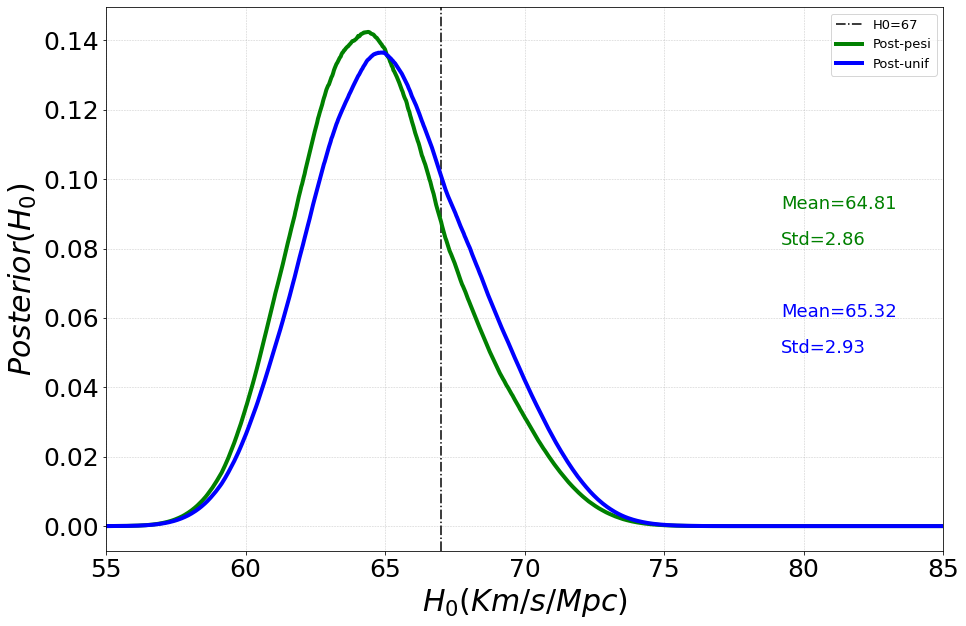

In [105]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post-pesi',color='g',linewidth=4,linestyle='solid')
ax.plot(x,totpost_like_unif/np.trapz(totpost_like_unif,x),label='Post-unif',color='b',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='g')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='g')

newdist=(totpost_like_unif)/np.trapz(totpost_like_unif,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c='b')
plt.figtext(0.75,0.4,'Std={:0.2f}'.format(std),fontsize=18, c='b')
ax.legend(fontsize=13, ncol=1)   

In [106]:
runpath='Pesi-extracted-nodenom-01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
beta_merge=np.loadtxt(runpath+'_beta.txt')
likelihood_merge=np.loadtxt(runpath +'_fullrun.txt')

NDS_merge=len(beta_merge)
final_post_merge=[]
for i in range(NDS_merge):
    final_post_merge.append(likelihood_merge[i]/beta_merge[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_merge[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_merge[i]*1))
        combined.append(num)
totpost_like=combined[-1]
#-------------------uniforme---------------------------------
runpath='EnzoTest_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

beta_unif=np.loadtxt(runpath+'_beta.txt')
likelihood_unif=np.loadtxt(runpath +'_fullrun.txt')

NDS_unif=len(beta_unif)
final_post_unif=[]
for i in range(NDS_unif):
    final_post_unif.append(likelihood_unif[i]/beta_unif[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_unif[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_unif[i]*1))
        combined.append(num)
totpost_like_unif=combined[-1]

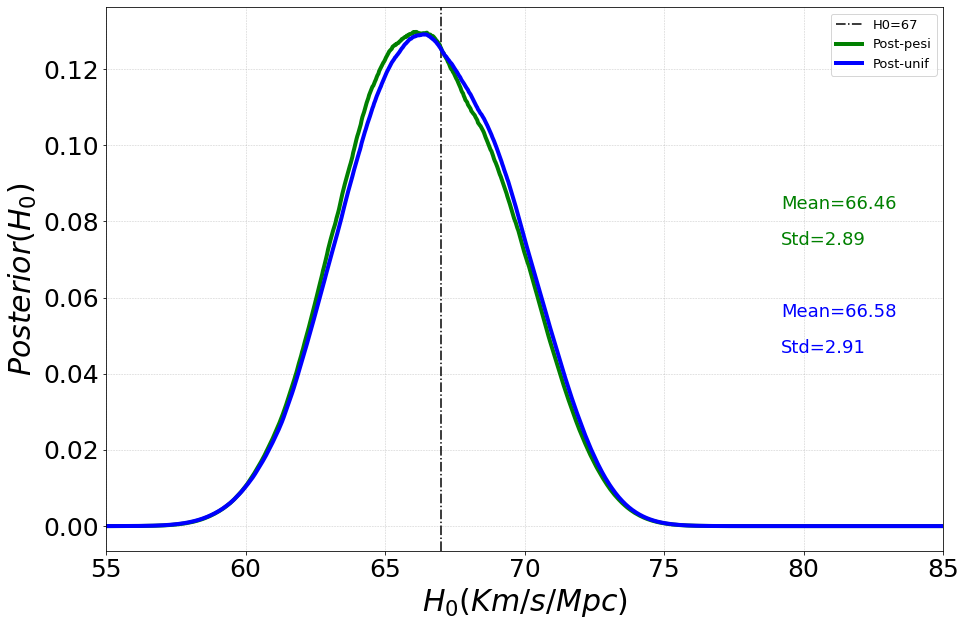

In [107]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post-pesi',color='g',linewidth=4,linestyle='solid')
ax.plot(x,totpost_like_unif/np.trapz(totpost_like_unif,x),label='Post-unif',color='b',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='g')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='g')

newdist=(totpost_like_unif)/np.trapz(totpost_like_unif,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c='b')
plt.figtext(0.75,0.4,'Std={:0.2f}'.format(std),fontsize=18, c='b')
ax.legend(fontsize=13, ncol=1)   

In [108]:
runpath='Pesi-extracted-nodenom-02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
beta_merge=np.loadtxt(runpath+'_beta.txt')
likelihood_merge=np.loadtxt(runpath +'_fullrun.txt')

NDS_merge=len(beta_merge)
final_post_merge=[]
for i in range(NDS_merge):
    final_post_merge.append(likelihood_merge[i]/beta_merge[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_merge[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_merge[i]*1))
        combined.append(num)
totpost_like=combined[-1]
#-------------------uniforme---------------------------------
runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

beta_unif=np.loadtxt(runpath+'_beta.txt')
likelihood_unif=np.loadtxt(runpath +'_fullrun.txt')

NDS_unif=len(beta_unif)
final_post_unif=[]
for i in range(NDS_unif):
    final_post_unif.append(likelihood_unif[i]/beta_unif[i])
combined=[]
for i in range(len(final_post_merge)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_unif[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_unif[i]*1))
        combined.append(num)
totpost_like_unif=combined[-1]

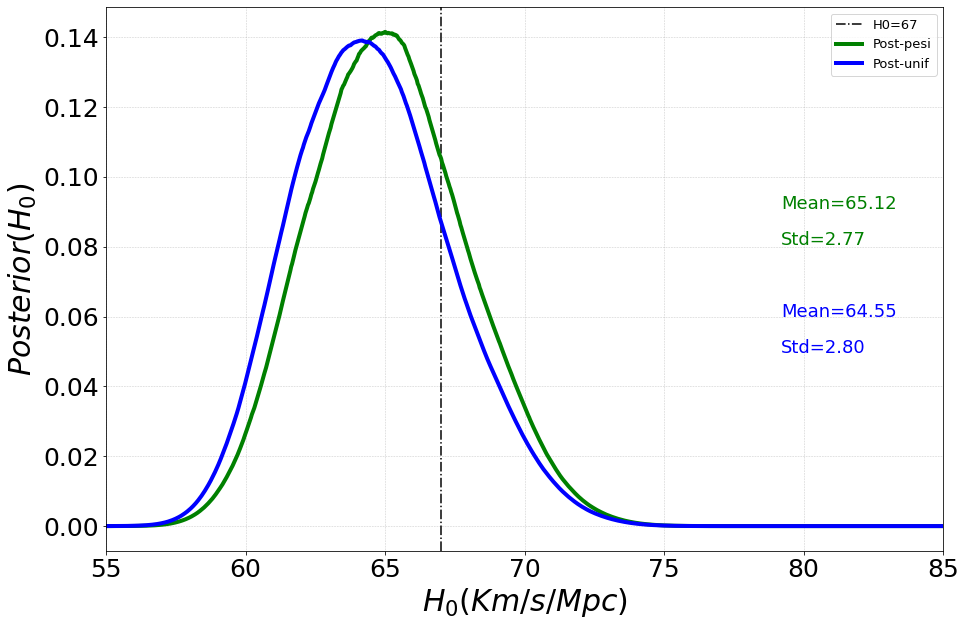

In [109]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

#for i in range(len(betatest)):
    #ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post-pesi',color='g',linewidth=4,linestyle='solid')
ax.plot(x,totpost_like_unif/np.trapz(totpost_like_unif,x),label='Post-unif',color='b',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c='g')
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c='g')

newdist=(totpost_like_unif)/np.trapz(totpost_like_unif,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c='b')
plt.figtext(0.75,0.4,'Std={:0.2f}'.format(std),fontsize=18, c='b')
ax.legend(fontsize=13, ncol=1)   

In [ ]:
2.93,1.71,1.32

In [226]:
1.71/1.32

1.2954545454545454

In [225]:
np.sqrt(900)/np.sqrt(450)

1.414213562373095

# N(z) DS

In [81]:
runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

In [82]:
ref_folder='/home/raul/DarkSirensStat/MyDSStat/'
cat_name='ExtractedFast.txt'#FullExplorer_big.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
Uniform_Cat.columns=colnames
#sample=sotto_tot#-----you find this before

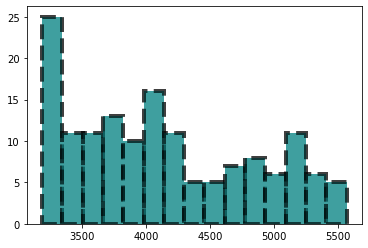

In [83]:
nbins=15
(n_ds, bins_ds, patches)=plt.hist(sample['Comoving Distance'],bins=nbins,
                                 range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')
dens=np.sum(n_ds)*np.diff(bins_ds)
dens=dens[0]
halfstep=(bins_ds[1]-bins_ds[0])/2
mypoints=bins_ds[0:-1]+halfstep

(n_unif, bins_unif, patches)=plt.hist(sample['Comoving Distance'],bins=nbins,
                                 range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')
dens_unif=np.sum(n_unif)*np.diff(bins_unif)
dens_unif=dens_unif[0]


Text(0, 0.5, '$N$')

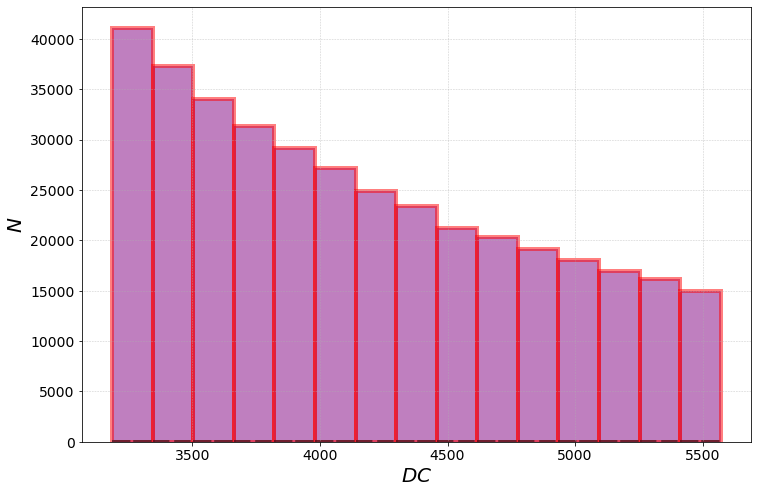

In [84]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=15
(n_unif, bins_unif, patches)=ax.hist(Uniform_Cat['Comoving Distance'],bins=nbins,
                                     range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                    density=False,color='purple',linestyle='solid',lw=4,alpha=0.5, edgecolor = 'r')
(n_ds, bins_ds, patches)=ax.hist(sample['Comoving Distance'],bins=nbins,
                                 range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')
#ax.errorbar(mypoints,n_ds,yerr=np.sqrt(n_ds/1),fmt='o',color='k')
#ax.errorbar(mypoints_unif,n_unif,yerr=np.sqrt(n_unif/1),fmt='o',color='purple')
ax.set_xlabel(r'$DC$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

499998 150 0.00030000120000480004


<ErrorbarContainer object of 3 artists>

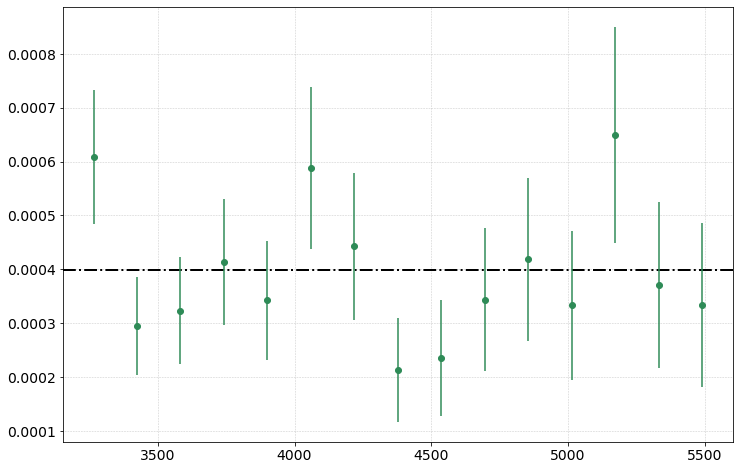

In [85]:
rapporto=n_ds/n_unif
print(Uniform_Cat.shape[0],sample.shape[0],sample.shape[0]/Uniform_Cat.shape[0])
trend=np.sum(n_ds)/np.sum(n_unif)

halfstep=(bins_unif[1]-bins_unif[0])/2
mypoints=bins_unif[0:-1]+halfstep

fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
#ax.scatter(mypoints,rapporto,color='seagreen')
ax.axhline(trend,linestyle="dashdot",color='k',linewidth=2)

rel_err_ds=np.sqrt(n_ds)/n_ds
rel_err_unif=np.sqrt(n_unif)/n_unif
rel_tot=rel_err_ds+rel_err_unif
tot_err=rel_tot*rapporto
ax.errorbar(mypoints,rapporto,yerr=tot_err,fmt='o',color='seagreen')

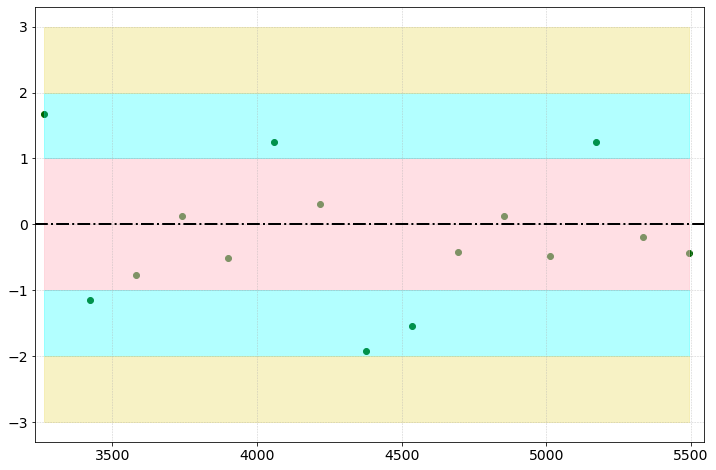

In [86]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

diff=(rapporto-trend)/tot_err

ax.scatter(mypoints,diff,color='darkgreen')
ax.axhline(0,linestyle="dashdot",color='k',linewidth=2)

ax.fill_between(mypoints,1,-1,color='pink',alpha=0.5)
ax.fill_between(mypoints,2,1,color='aqua',alpha=0.3)
ax.fill_between(mypoints,-2,-1,color='aqua',alpha=0.3)
ax.fill_between(mypoints,3,2,color='khaki',alpha=0.5)
ax.fill_between(mypoints,-3,-2,color='khaki',alpha=0.5)
diff = diff[~np.isnan(diff)]
ylim=np.max(np.abs(diff))+np.max(np.abs(diff))*10/100
#ax.set_ylim(-3.5,3.5)
ax.set_xlim(np.min(mypoints)-np.min(mypoints)*1/100,np.max(mypoints)+np.max(mypoints)*1/100)
os.chdir(ref_folder)
#plt.savefig('Mega_run.pdf')

15.500499327574243 15 1.0333666218382829
150 0.9106954133478692 2.1730372547534005 0.8000002187853561 2.499996380543656


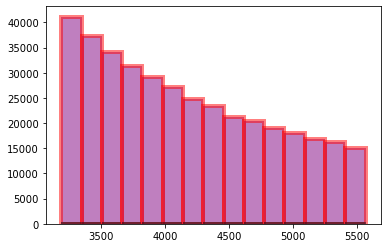

In [87]:
nbins=15

(n_unif, bins_unif, patches)=plt.hist(Uniform_Cat['Comoving Distance'],bins=nbins,
                                     range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                    density=False,color='purple',linestyle='solid',lw=4,alpha=0.5, edgecolor = 'r')
(n_ds, bins_ds, patches)=plt.hist(sample['Comoving Distance'],bins=nbins,
                                 range=(np.min(sample['Comoving Distance']),np.max(sample['Comoving Distance'])),
                                density=False,color='teal',linestyle='--',lw=4,alpha=0.5, edgecolor = 'k')
cc=np.sum(n_ds)/np.sum(n_unif)
to_sum_chi=((n_ds-n_unif*cc)**2)/(n_ds)
to_sum_chi = to_sum_chi[~np.isinf(to_sum_chi)]
chisq=np.sum(to_sum_chi)
print(chisq,nbins,chisq/nbins)
print(sample.shape[0],sample['z'].min(),sample['z'].max(),Uniform_Cat['z'].min(),Uniform_Cat['z'].max())


# Outsiders

In [97]:
####### Catalogo Host di riferimento #########################
ref_folder='/home/raul/DarkSirensStat/MyDSStat/'
cat_name='FullExplorer_big.txt'#FullExplorer_big.txt#ExtractedFast.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
Uniform_Cat.columns=colnames

cat_dlmax=Uniform_Cat['Luminosity Distance'].max()
cat_dlmin=Uniform_Cat['Luminosity Distance'].min()

runpath='Agosto5-FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='Mega450-FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='BorderCheck_FullBig_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='BorderCheck_FullBig_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='BorderCheck_FullBig_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

####### Catalogo Host di riferimento #########################
ref_folder='/home/raul/DarkSirensStat/MyDSStat/'
cat_name='ExtractedFast.txt'#FullExplorer_big.txt#ExtractedFast.txt
#datapath=os.path.join(ref_folder,cat_name)
os.chdir(ref_folder)

Uniform_Cat = pd.read_csv(cat_name, sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
Uniform_Cat.columns=colnames

cat_dlmax=Uniform_Cat['Luminosity Distance'].max()
cat_dlmin=Uniform_Cat['Luminosity Distance'].min()

runpath='EnzoTest_00'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='EnzoTest_01'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))

runpath='EnzoTest_02'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

sample = pd.read_csv(runpath +'_DSs.txt', sep=" ", header=None)
if sample.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if sample.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
sample.columns=colnames

ds_min=sample['scattered DL'].min()
ds_max=sample['scattered DL'].max()
print(runpath)
print('Dl massima Host={} Dl massima DS={}, diff={}'.format(cat_dlmax,ds_max,cat_dlmax-ds_max))
print('Dl minima Host={} Dl minima DS={} diff={}\n'.format(cat_dlmin,ds_min,ds_min-cat_dlmin))


Agosto5-FullBig_00
Dl massima Host=20944.797544104 Dl massima DS=19648.508216446924, diff=1296.2893276570758
Dl minima Host=233.15540453911171 Dl minima DS=2422.2351716579883 diff=2189.0797671188766

Mega450-FullBig_00
Dl massima Host=20944.797544104 Dl massima DS=21901.269016613085, diff=-956.4714725090853
Dl minima Host=233.15540453911171 Dl minima DS=474.7485464967944 diff=241.5931419576827

BorderCheck_FullBig_00
Dl massima Host=20944.797544104 Dl massima DS=15173.606028266337, diff=5771.191515837663
Dl minima Host=233.15540453911171 Dl minima DS=1759.219400659012 diff=1526.0639961199004

BorderCheck_FullBig_01
Dl massima Host=20944.797544104 Dl massima DS=15841.481472074138, diff=5103.316072029862
Dl minima Host=233.15540453911171 Dl minima DS=1818.1368773666788 diff=1584.9814728275671

BorderCheck_FullBig_02
Dl massima Host=20944.797544104 Dl massima DS=15736.59916471687, diff=5208.1983793871295
Dl minima Host=233.15540453911171 Dl minima DS=931.0822927346552 diff=697.92688819554

In [ ]:
likes=np.loadtxt(runpath +'_fullrun.txt')
NDS=np.shape(likes)[0]
#mybeta=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/MyBeta/MyBeta_beta.txt')

# Correlation H0-Z_med

In [ ]:
from astropy.cosmology import FlatLambdaCDM

In [186]:
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
def E_z(z, Om=Om0GLOB):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def Psi(z, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, Om=Om0GLOB)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c
def r_z(z, H0, Om=Om0GLOB):
    c = clight
    integrand = lambda x : 1/E_z(x, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

In [187]:
z_med=np.median(sample['z'])
#dl_scatter_med=np.median(sample['scattered DL'])
dl_med=np.median(sample['Luminosity Distance'])
print(z_med,dl_scatter_med,dl_med)

1.3493629129473497 12092.391245018203 9869.385449525911


In [191]:
H0_med=Psi(z_med)/dl_med
print(H0_med,r_z(1,67))

28.51836923580995 3413.6913570557676


In [179]:
Num=3
position=[]
volume=[]
numobj=[]
step=(np.max(sample['Comoving Distance'])-np.min(sample['Comoving Distance']))/Num
start=np.min(sample['Comoving Distance'])
for i in range(Num):
    tmp=step/2 + start+(step)*i
    position.append(tmp)
    tmpnum=sample['Comoving Distance'][sample['Comoving Distance']<tmp]
    numobj.append(len(tmpnum))
    volume.append(tmp**3-start**3)
position=np.asarray(position)
volume=np.asarray(volume)
volume=volume/np.min(volume)
tmp=sample['Comoving Distance'][sample['Comoving Distance']<=(start+step)]
norm=numobj[0]
volume=volume*norm

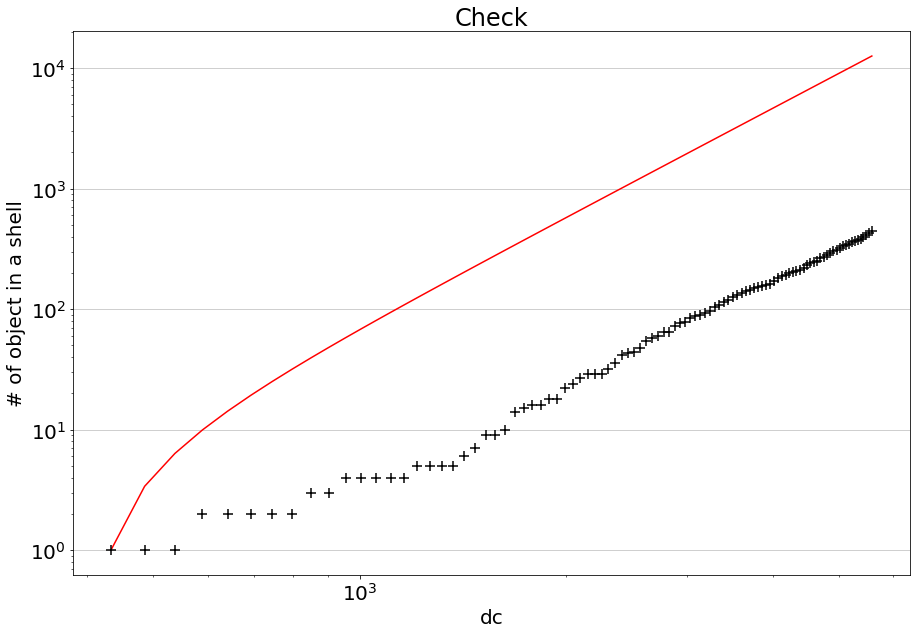

In [180]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
#values=tmp_flag['dl'].hist(grid=True, bins=Num, rwidth=0.9,color='#607c8e')
#plt.hist(fast_alldc,bins=Num,rwidth=0.9,color='#607c8e')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.xscale('log')
plt.yscale('log')
plt.title('Check')

plt.plot(position,volume,color='r')
plt.xlabel('dc')
plt.ylabel('# of object in a shell')
plt.grid(axis='y', alpha=0.75)

In [184]:
save_cat_path='/home/rciancarella/DarkSirensStat/MyDSStat/'
os.chdir(save_cat_path)
test = pd.read_csv('CuttedFast.txt', sep=" ", header=None)
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
extracted_test = pd.read_csv('ExtractedFast.txt', sep=" ", header=None)
test.columns=colnames
extracted_test.columns=colnames

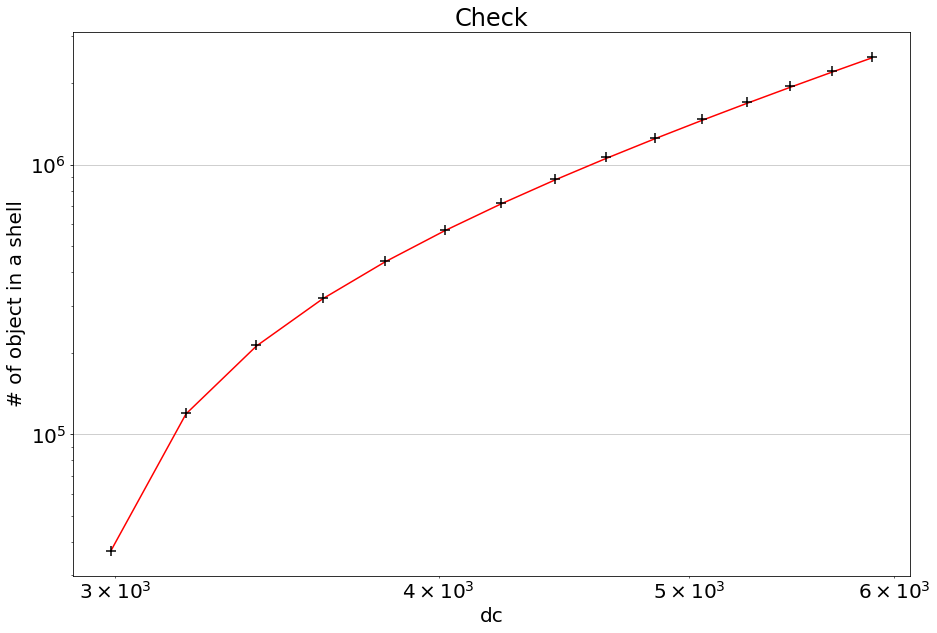

In [185]:
Num=15
position=[]
volume=[]
numobj=[]
step=(np.max(test['Comoving Distance'])-np.min(test['Comoving Distance']))/Num
start=np.min(test['Comoving Distance'])
for i in range(Num):
    tmp=step/2 + start+(step)*i
    position.append(tmp)
    tmpnum=test['Comoving Distance'][test['Comoving Distance']<tmp]
    numobj.append(len(tmpnum))
    volume.append(tmp**3-start**3)
position=np.asarray(position)
volume=np.asarray(volume)
volume=volume/np.min(volume)
tmp=test['Comoving Distance'][test['Comoving Distance']<=(start+step)]
norm=numobj[0]
volume=volume*norm
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
#values=tmp_flag['dl'].hist(grid=True, bins=Num, rwidth=0.9,color='#607c8e')
#plt.hist(fast_alldc,bins=Num,rwidth=0.9,color='#607c8e')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.xscale('log')
plt.yscale('log')
plt.title('Check')

plt.plot(position,volume,color='r')
plt.xlabel('dc')
plt.ylabel('# of object in a shell')
plt.grid(axis='y', alpha=0.75)

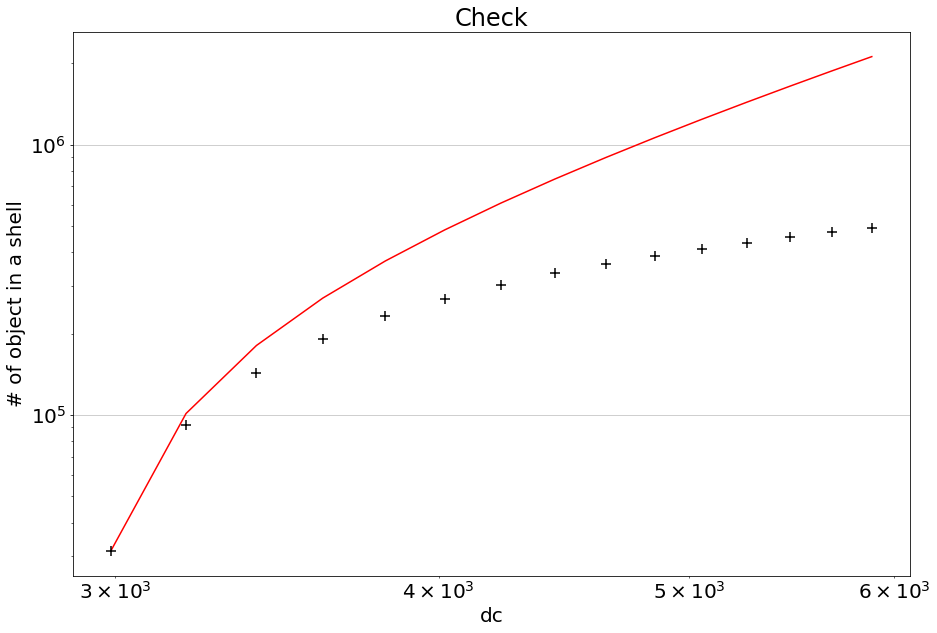

In [186]:
Num=15
position=[]
volume=[]
numobj=[]
step=(np.max(extracted_test['Comoving Distance'])-np.min(extracted_test['Comoving Distance']))/Num
start=np.min(extracted_test['Comoving Distance'])
for i in range(Num):
    tmp=step/2 + start+(step)*i
    position.append(tmp)
    tmpnum=extracted_test['Comoving Distance'][extracted_test['Comoving Distance']<tmp]
    numobj.append(len(tmpnum))
    volume.append(tmp**3-start**3)
position=np.asarray(position)
volume=np.asarray(volume)
volume=volume/np.min(volume)
tmp=extracted_test['Comoving Distance'][extracted_test['Comoving Distance']<=(start+step)]
norm=numobj[0]
volume=volume*norm
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
#values=tmp_flag['dl'].hist(grid=True, bins=Num, rwidth=0.9,color='#607c8e')
#plt.hist(fast_alldc,bins=Num,rwidth=0.9,color='#607c8e')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.xscale('log')
plt.yscale('log')
plt.title('Check')

plt.plot(position,volume,color='r')
plt.xlabel('dc')
plt.ylabel('# of object in a shell')
plt.grid(axis='y', alpha=0.75)